# Preliminary image processing task
* CUDA, cuDNN, and cuBLAS libraries support for GPU acceleration - Yet to be done. 
* Pre-trained Convolutional Neural Networks (CNNs) such as VGG, MobileNet, DenseNet, ResNet, InceptionV4, and CoCa
* Dropout layers with a dropout rate of 0.2 to prevent overfitting
* Reduce batch sizes from 64 or 32 if memory limitations
* train each model for 30 epochs initially, but adjust the number of epochs based on the observed accuracy during training.


Imports

In [22]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.optim as optim
import os
import random
import shutil
from torchvision import datasets
from csvlogger import CSVLogger

In [23]:
avail_pretrained_models = timm.list_models(pretrained=True)
print(avail_pretrained_models)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

Check GPU

In [24]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


Loading a few pre-trained models (Re run this once the epochs are done for the first one, and comment the first one out so that we don't lose our evaluation results)

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

# resnet = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)
# vgg16 = timm.create_model('vgg16', pretrained=True, num_classes=2, drop_rate=0.2).to(device)
vgg = timm.create_model('vgg19', pretrained=True, num_classes=2, drop_rate=0.2).to(device)
# mobilenet = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=2, drop_rate=0.2).to(device)
# densenet = timm.create_model('densenet121', pretrained=True, num_classes=2, drop_rate=0.2).to(device)
# inceptionv4 = timm.create_model('inception_v4', pretrained=True, num_classes=2, drop_rate=0.2).to(device)
# coca = timm.create_model('coca_s', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

Device: cuda


Check Path Accuracy

In [26]:
print(os.listdir('Alzheimer_s Dataset_binary\\src')) # Preliminary Image Processing\Alzheimer_s Dataset_binary\src
print(os.listdir('Alzheimer_s Dataset_binary\\train'))
print(os.listdir('Alzheimer_s Dataset_binary\\test'))
print(os.listdir('Alzheimer_s Dataset_binary\\val'))

['Demented', 'Non-Demented']
['Demented', 'Non-Demented']
['Demented', 'Non-Demented']
['Demented', 'Non-Demented']


Train Test Validation Split

In [6]:
# Define the source folder containing subfolders for each class
source_folder = 'Alzheimer_s Dataset_binary\\src'
train_folder = 'Alzheimer_s Dataset_binary\\train'
test_folder = 'Alzheimer_s Dataset_binary\\test'
val_folder = 'Alzheimer_s Dataset_binary\\val'

# Define the ratios for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Create destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# List subfolders (classes) in the source folder
classes = os.listdir(source_folder)

# Loop through each class
for class_name in classes:
    class_source_folder = os.path.join(source_folder, class_name)
    class_train_folder = os.path.join(train_folder, class_name)
    class_test_folder = os.path.join(test_folder, class_name)
    class_val_folder = os.path.join(val_folder, class_name)

    # List image files in the class source folder
    image_files = os.listdir(class_source_folder)
    random.shuffle(image_files)

    # Calculate the number of images for each set based on the defined ratios
    total_images = len(image_files)
    train_split = int(total_images * train_ratio)
    test_split = int(total_images * test_ratio)

    # Copy image files to their respective folders for train, test, and validation
    for i, image_file in enumerate(image_files):
        source_path = os.path.join(class_source_folder, image_file)
        if i < train_split:
            destination_folder = class_train_folder
        elif i < train_split + test_split:
            destination_folder = class_test_folder
        else:
            destination_folder = class_val_folder

        destination_path = os.path.join(destination_folder, image_file)
        shutil.copyfile(source_path, destination_path)


Batch Creation

In [27]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/train', transform=transform)
test_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/test', transform=transform)
val_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/val', transform=transform)

batch_size = 26  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

178
36
36
4604
918
919


Resnet

In [10]:
loss_value = torch.nn.CrossEntropyLoss()

resnet_opt = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30  
early_stopping = False  
best_loss = float('inf') 
patience = 5 

for epoch in range(num_epochs):
    resnet.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        resnet_opt.zero_grad()
        outputs = resnet(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        resnet_opt.step()
    
    # Validation
    resnet.eval()  
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = resnet(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
    val_loss /= len(val_loader)
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break

# -----------------------------------------

correct = 0
total = 0
resnet.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('\n\nAccuracy on the test dataset: {:.2f}%'.format(accuracy))


Completed epoch 1 with loss 0.5972965955734253, validation loss 0.662198635439078
Completed epoch 2 with loss 0.7139240503311157, validation loss 0.6726262635654874
Completed epoch 3 with loss 0.703946053981781, validation loss 0.6943394367893537
Completed epoch 4 with loss 0.6387301683425903, validation loss 0.6387741545008289
Completed epoch 5 with loss 0.6101664304733276, validation loss 0.5739335707492299
Completed epoch 6 with loss 0.4487069547176361, validation loss 0.5758718889620569
Completed epoch 7 with loss 0.5640740990638733, validation loss 0.562455779976315
Completed epoch 8 with loss 0.49725598096847534, validation loss 0.546795973347293
Completed epoch 9 with loss 0.42574071884155273, validation loss 0.532713406615787
Completed epoch 10 with loss 0.2875150442123413, validation loss 0.562677327129576
Completed epoch 11 with loss 0.43426617980003357, validation loss 0.5070842413438691
Completed epoch 12 with loss 0.5006571412086487, validation loss 0.6812141231364675
Comp

Vgg

In [28]:
import datetime

loss_value = torch.nn.CrossEntropyLoss()
losslogger = CSVLogger("lossLogVGG19.csv", fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss"])
acclogger = CSVLogger("accLogVGG19.csv", fieldnames=["datetime", "average_accuracy"])
vgg_opt = optim.SGD(vgg.parameters(), lr=0.0001, momentum=0.9)

# Training loop
num_epochs = 100
early_stopping = False  
best_loss = float('inf') 
patience = 5 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")

for epoch in range(num_epochs):
    vgg.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        vgg_opt.zero_grad()
        outputs = vgg(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        vgg_opt.step()
    
    # Validation
    vgg.eval()  
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = vgg(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
    val_loss /= len(val_loader)
    
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss}
    losslogger.log(losslog_data)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break

    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}, Time: {datetime.datetime.now()}")

# -----------------------------------------

correct = 0
total = 0
vgg.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.2f}%'.format(accuracy))


Device: cuda
Start time: 2023-10-31 12:04:06.034180
Completed epoch 1 with loss 0.551813006401062, validation loss 0.569898878534635, Time: 2023-10-31 12:09:34.310484
Completed epoch 2 with loss 1.1132676601409912, validation loss 0.5127274841070175, Time: 2023-10-31 12:14:58.074694
Completed epoch 3 with loss 0.25208526849746704, validation loss 0.4791238241725498, Time: 2023-10-31 12:20:36.146095
Completed epoch 4 with loss 1.200052261352539, validation loss 0.5205730599247747, Time: 2023-10-31 12:27:13.616873
Completed epoch 5 with loss 0.11781418323516846, validation loss 0.38156748480266994, Time: 2023-10-31 12:32:02.861595
Completed epoch 6 with loss 0.048300839960575104, validation loss 0.4345532359762324, Time: 2023-10-31 12:38:38.290210
Completed epoch 7 with loss 0.17378337681293488, validation loss 0.6576914992959549, Time: 2023-10-31 12:47:40.647235
Completed epoch 8 with loss 0.0032130032777786255, validation loss 0.4077589597242574, Time: 2023-10-31 12:56:39.911847
Comple

In [31]:
%pip install pyarrow

  Obtaining dependency information for pyarrow from https://files.pythonhosted.org/packages/f1/04/0c0589aea14748b310489361f732ee813aa9cda0736933d7af8d0225654c/pyarrow-13.0.0-cp310-cp310-win_amd64.whl.metadata
  Using cached pyarrow-13.0.0-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
Using cached pyarrow-13.0.0-cp310-cp310-win_amd64.whl (24.3 MB)
Note: you may need to restart the kernel to use updated packages.


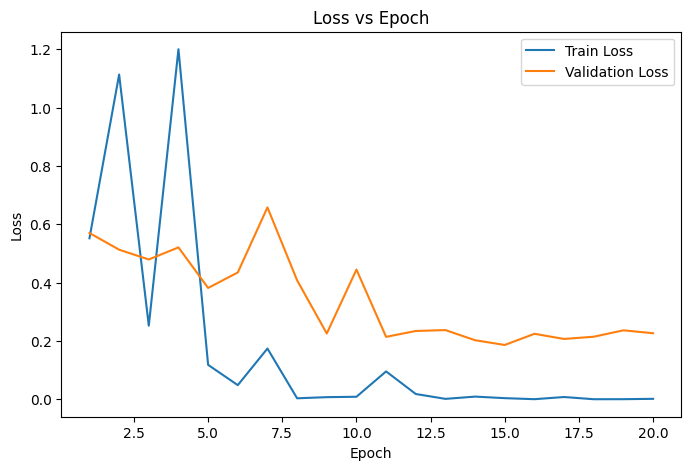

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

lossdf = pd.read_csv("lossLogVGG19.csv", engine="pyarrow")
accdf = pd.read_csv("accLogVGG19.csv", engine="pyarrow")

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["train_loss"], label="Train Loss")
plt.plot(lossdf["epoch"], lossdf["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()


Mobilenet

In [12]:
loss_value = torch.nn.CrossEntropyLoss()

mobilenet_opt = optim.SGD(mobilenet.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30  
early_stopping = False  
best_loss = float('inf') 
patience = 5 

for epoch in range(num_epochs):
    mobilenet.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        mobilenet_opt.zero_grad()
        outputs = mobilenet(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        mobilenet_opt.step()
    
    # Validation
    mobilenet.eval()  
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = mobilenet(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
    val_loss /= len(val_loader)
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break

# -----------------------------------------

correct = 0
total = 0
mobilenet.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('\n\nAccuracy on the test dataset: {:.2f}%'.format(accuracy))


Completed epoch 1 with loss 0.7445648312568665, validation loss 0.6043489978959163
Completed epoch 2 with loss 0.19247862696647644, validation loss 0.5476116006676521
Completed epoch 3 with loss 0.24822600185871124, validation loss 0.5780754101116246
Completed epoch 4 with loss 0.023607904091477394, validation loss 0.25335530386332217
Completed epoch 5 with loss 0.022079359740018845, validation loss 0.19679576785468575
Completed epoch 6 with loss 0.07140202820301056, validation loss 0.21156224173804125
Completed epoch 7 with loss 0.006242365576326847, validation loss 0.28764441644175853
Completed epoch 8 with loss 0.00026606657775118947, validation loss 0.15315801704764453
Completed epoch 9 with loss 0.0002453562628943473, validation loss 0.19076891623707423
Completed epoch 10 with loss 5.692768536391668e-05, validation loss 0.1418735117838676
Completed epoch 11 with loss 0.1272803544998169, validation loss 0.25029791052803474
Completed epoch 12 with loss 0.27927345037460327, validatio

Densenet

In [5]:
import datetime

loss_value = torch.nn.CrossEntropyLoss()
losslogger = CSVLogger("lossLogDensenet_noKFold.csv", fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss"])
acclogger = CSVLogger("accLogDensenet_noKFold.csv", fieldnames=["datetime", "average_accuracy"])
densenet_opt = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)
results = []

# Training loop
num_epochs = 30  
early_stopping = False  
best_loss = float('inf') 
patience = 5 

for epoch in range(num_epochs):
    densenet.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        densenet_opt.zero_grad()
        outputs = densenet(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        densenet_opt.step()
    
    # Validation
    densenet.eval()  
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = densenet(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
    val_loss /= len(val_loader)
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss}
    losslogger.log(losslog_data)
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break

# -----------------------------------------

correct = 0
total = 0
densenet.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.3f}%'.format(accuracy))


Completed epoch 1 with loss 0.8082890510559082, validation loss 0.45577654987573624
Completed epoch 2 with loss 0.08162737637758255, validation loss 0.31445615448885494
Completed epoch 3 with loss 0.862658679485321, validation loss 0.23910708231334057
Completed epoch 4 with loss 0.5395433902740479, validation loss 0.15274034877721634
Completed epoch 5 with loss 0.0020622117444872856, validation loss 0.11112211865838617
Completed epoch 6 with loss 0.5829416513442993, validation loss 0.12856986587091038
Completed epoch 7 with loss 0.6586921811103821, validation loss 0.2387236801668122


KeyboardInterrupt: 

Inceptionv4

In [14]:
loss_value = torch.nn.CrossEntropyLoss()

inceptionv4_opt = optim.SGD(inceptionv4.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30  
early_stopping = False  
best_loss = float('inf') 
patience = 5 

for epoch in range(num_epochs):
    inceptionv4.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inceptionv4_opt.zero_grad()
        outputs = inceptionv4(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        inceptionv4_opt.step()
    
    # Validation
    inceptionv4.eval()  
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = inceptionv4(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
    val_loss /= len(val_loader)
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break

# -----------------------------------------

correct = 0
total = 0
inceptionv4.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = inceptionv4(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('\n\nAccuracy on the test dataset: {:.2f}%'.format(accuracy))


Completed epoch 1 with loss 0.5729765295982361, validation loss 0.5034215864208009
Completed epoch 2 with loss 0.33148831129074097, validation loss 0.4140690445072121
Completed epoch 3 with loss 0.11480871587991714, validation loss 0.2912245374172926
Completed epoch 4 with loss 0.01429636962711811, validation loss 0.13900020946231154
Completed epoch 5 with loss 0.01847616583108902, validation loss 0.1619707698571599
Completed epoch 6 with loss 0.0319196954369545, validation loss 0.16890166338352072
Completed epoch 7 with loss 0.004581802524626255, validation loss 0.17587602535624886
Completed epoch 8 with loss 0.04067014530301094, validation loss 0.13350597533604336
Completed epoch 9 with loss 0.003873853012919426, validation loss 0.1274900399795216
Completed epoch 10 with loss 0.048844993114471436, validation loss 0.1319852301902655
Completed epoch 11 with loss 0.0027840337716042995, validation loss 0.09555844770834988
Completed epoch 12 with loss 0.0019335746765136719, validation los

Exporting the models

In [ ]:
torch.save(vgg, 'vgg19.pth')
# torch.save(mobilenet, 'mobilenetv3.pth')
# torch.save(densenet, 'densenet121.pth')
# torch.save(inceptionv4, 'inception_v4.pth')
# torch.save(resnet, 'resnet50.pth')

# Overfit check

#### New split train-test-validation for overfitting check, we will skip training and only check test values

Loading the datasets

In [8]:
densenet2 = torch.load('densenet121.pth')
inception2 = torch.load('inception_v4.pth')
mobilenet2 = torch.load('mobilenetv3.pth')
resnet2 = torch.load('resnet50.pth')
vgg2 = torch.load('vgg16.pth')

Creating train-test-splits

In [11]:
# Define the source folder containing subfolders for each class
source_folder = 'Alzheimer_s Dataset_binary\\src'
train_folder = 'Alzheimer_s Dataset_binary\\ctrain'
test_folder = 'Alzheimer_s Dataset_binary\\ctest'
val_folder = 'Alzheimer_s Dataset_binary\\cval'

# Define the ratios for train, test, and validation sets
train_ratio = 0.75
test_ratio = 0.15
val_ratio = 0.10

# Create destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# List subfolders (classes) in the source folder
classes = os.listdir(source_folder)

# Loop through each class
for class_name in classes:
    class_source_folder = os.path.join(source_folder, class_name)
    class_train_folder = os.path.join(train_folder, class_name)
    class_test_folder = os.path.join(test_folder, class_name)
    class_val_folder = os.path.join(val_folder, class_name)

    # List image files in the class source folder
    image_files = os.listdir(class_source_folder)
    random.shuffle(image_files)

    # Calculate the number of images for each set based on the defined ratios
    total_images = len(image_files)
    train_split = int(total_images * train_ratio)
    test_split = int(total_images * test_ratio)

    # Copy image files to their respective folders for train, test, and validation
    for i, image_file in enumerate(image_files):
        source_path = os.path.join(class_source_folder, image_file)
        if i < train_split:
            destination_folder = class_train_folder
        elif i < train_split + test_split:
            destination_folder = class_test_folder
        else:
            destination_folder = class_val_folder

        destination_path = os.path.join(destination_folder, image_file)
        shutil.copyfile(source_path, destination_path)


Loading the train-test-splits

In [12]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/ctrain', transform=transform)
test_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/ctest', transform=transform)
val_dataset = ImageFolder(root='Alzheimer_s Dataset_binary/cval', transform=transform)

batch_size = 26  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

177
36
24
4590
918
613


Evaluation

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

correct = 0
total = 0
densenet2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('\n\nAccuracy on the test dataset: {:.2f}%'.format(accuracy))

Device: cuda


Accuracy on the test dataset: 99.56%
